In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch_lr_finder import LRFinder

import matplotlib.pyplot as plt
%matplotlib inline
import os
from pathlib import Path
import re
import numpy as np
import datetime

import AerofoilDataset as AD
from utils import *
import ShowAerofoil as show
from train_model import *
from test_model import *

  pip install torch-lr-finder -v --global-option="amp"


In [2]:
# device configuration
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# paths and files
path = Path().parent
time_of_run = datetime.datetime.now().strftime("D%d_%m_%Y_T%H_%M_%S")

def _dir(folder):
    return path / ('storage/aerofoils' if torch.cuda.is_available() else '') / folder
train_dir = _dir('data/out/train')
valid_dir = _dir('data/out/valid')
test_dir = _dir('data/out/test')
print_dir = _dir('/'.join(('print', time_of_run)))
print_dir.mkdir()

In [4]:
# hyper parameters
hidden_layers = [50]
# convolutions = [6, 16, 32]  for ConvNet
convolutions = [64, 46, 46, 30]  # input/output channels of convolutions
num_epochs = 1
batch_size = 5
learning_rate = 0.01
dense_out_size = 32

checkpoint_every = 5  # make a checkpoint every n epochs
print_every = 1  # calculate and print output & plot losses after n epochs (after doing all batches within epoch)

In [5]:
# input size, output size and number of channels of data
coords = np.loadtxt(train_dir / os.listdir(train_dir)[0], delimiter=" ", dtype=np.float32, skiprows=1)  # coords of sample
input_size = len(coords)
with open(train_dir / os.listdir(train_dir)[0]) as f:
    output_size = len([num for num in re.findall(r'[+-]?\d*[.]?\d*', f.readline()) if num != ''])  # outputs of sample are on first line of file
num_channels = 1  # one channel for y coordinate (xy coordinates requires two channels)

In [6]:
# import datasets
def _dataset(directory, num_channels, input_size, output_size):
    return AD.AerofoilDataset(directory, num_channels, input_size, output_size,
                              transform=transforms.Compose([AD.NormaliseYValues(train_dir)]))  # all datasets use same scaling as training set
train_dataset = _dataset(train_dir, num_channels, input_size, output_size)
valid_dataset = _dataset(valid_dir, num_channels, input_size, output_size)
test_dataset = _dataset(test_dir, num_channels, input_size, output_size)

In [7]:
# dataloaders
def _dataloader(dataset, batch_size, shuffle):
    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)
train_loader = _dataloader(train_dataset, batch_size, shuffle=True)
valid_loader = _dataloader(valid_dataset, batch_size*2, shuffle=False)  # not storing gradients, so can double bs
test_loader = _dataloader(test_dataset, 1, shuffle=False)  # bs=1 required for top_losses()

In [8]:
# model, loss, optimiser, checkpoint
model = DenseNet(input_size, output_size, convolutions, hidden_layers, num_channels, dense_out_size).to(device)
# model = ConvNet(input_size, convolutions, num_channels, hidden_layers, output_size).to(device)
criterion = metrics.MyLossFunc()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=5, verbose=True)

checkpoint = {'architecture':{'hidden_layers':hidden_layers, 'convolutions':convolutions,   # initialise
                              'num_channels':num_channels, 'input_size':input_size, 'output_size':output_size,
                              'dense_out_size':dense_out_size, 'optimiser':optimiser, 'scheduler':scheduler,
                              'criterion':criterion},
              'extras':{'print_dir':print_dir},
              'hyperparameters':{'num_epochs':num_epochs, 'batch_size':batch_size, 'learning_rate':learning_rate}}
model

DenseNet(
  (lowconv): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (relu): ReLU()
  (block_and_layer): ModuleList(
    (0): Sequential(
      (0): DenseBlock(
        (relu): ReLU(inplace=True)
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dense_block): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): Conv1d(96, 32, kernel_size=(3,), stride=(1,), padding=(1,))
          (2): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (1): TransitionLayer(
        (relu): ReLU(inplace=True)
        (bn): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv): Conv1d(160, 46, kernel_size=(1,), stride=(1,), bias=False)
        (avg_pool): AvgPool1d(kernel_size=(3,), stride=(2,), padding=(0,))
      )
    )
    (1): Sequential(
      (0): DenseBlock(
        (relu): ReLU(inplace=True)
    

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


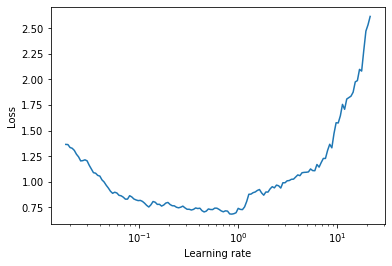

In [9]:
# find learning rate
assert learning_rate > 0.0001, 'Selected initial learning rate too high'
lr_finder = LRFinder(model, optimiser, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=200, num_iter=200)
lr_finder.plot()
lr_finder.reset()  # reset model and optimizer to their initial state

In [9]:
# train model
model, checkpoints = train(model, optimiser, criterion, num_epochs, train_dataset, valid_dataset, train_loader, 
                           valid_loader, checkpoint, scheduler=scheduler, writer=False, print_every=5, 
                           checkpoint_every=None, device=device)

epoch 1/1, batch 247/247.
Training loss = 0.6345, Validation loss = 0.5043



In [10]:
torch.save(checkpoints[-1], 'last_checkpoint.pth')

In [11]:
model, architecture, hyperparameters, extras = load_model('last_checkpoint.pth')

In [15]:
test(model, test_loader, test_dataset, architecture['criterion'], hyperparameters['num_epochs'], extras['print_dir'], 
     architecture['output_size'], device=device)

Test set results:
Running test loss = 0.3776
ClCd RMS: 0.55, angle RMS: 0.69


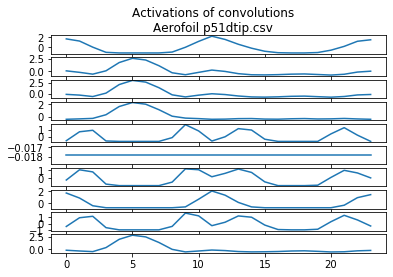

In [13]:
activations(model, num_epochs, test_loader, num_activations=10)

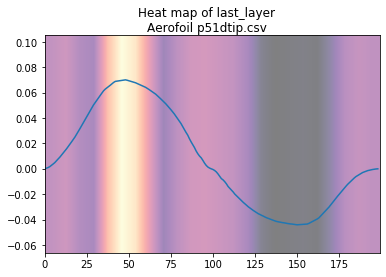

In [14]:
heat_map(model, input_size, num_epochs, dataloader=test_loader, layer=-1, writer=False, device=device)

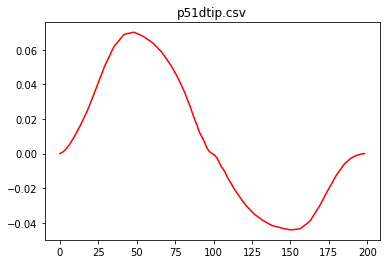

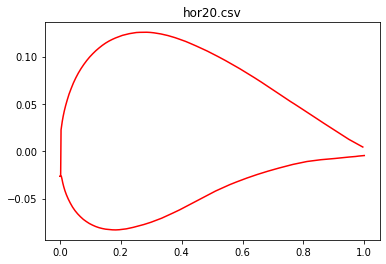

In [12]:
coordinates, _, aerofoil_name = next(iter(test_loader))
show.from_dataloader(coordinates, aerofoil_name[0])
show.from_file(test_dir / 'hor20.csv')

In [ ]:
# use Tensorboard
TB_process, writer = use_tensorboard(print_dir)

In [ ]:
# computational graph
for sample in train_loader:
        writer.add_graph(model, sample[0].float())
writer.close()

In [ ]:
# kill TensorBoard
kill_tensorboard(TB_process)